In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-v15r14wp
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-v15r14wp
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit beb9f7d70d20aa326de005d6f4e4cc6026d1c539
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt

from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter


from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
#from torch_geometric.explain import Explainer, GNNExplainer
import torch_geometric.nn as gnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [5]:
Explainability_name = 'GNNExplainer'
Task_name = 'Graph Classification'
Model_Name = "DIFFPOOL"
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.5
classifier_weight_decay = 1e-6
classifier_bias = True
DataSet_name = "MUTAG"

File_Name = Model_Name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [6]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [7]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [8]:
BATCH_SIZE = 64
size_of_hidden_layers = 7

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
print(train_dataloader.batch_size)
batch = next(iter(train_dataloader))
print(batch.y)
print(len(train_dataloader))

64
tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])
3


In [10]:
size_list = []
for graph in dataset:
    size_list.append(len(graph.x))
print("size_list: ", size_list)
print("AVG. size_list: ", sum(size_list)/len(size_list))
print("25% of the avg #of nodes: ", 0.25 * sum(size_list)/(len(size_list)))

size_list:  [17, 13, 13, 19, 11, 28, 16, 20, 12, 17, 17, 20, 22, 13, 19, 22, 11, 17, 13, 18, 18, 17, 23, 27, 17, 13, 23, 17, 23, 23, 22, 24, 23, 13, 17, 14, 17, 15, 15, 13, 17, 13, 19, 17, 12, 23, 22, 17, 20, 16, 26, 26, 19, 19, 14, 17, 21, 25, 23, 19, 17, 11, 23, 20, 16, 16, 20, 23, 19, 14, 26, 16, 16, 23, 18, 10, 16, 16, 17, 19, 12, 25, 16, 11, 23, 23, 16, 12, 13, 23, 25, 19, 23, 19, 19, 25, 18, 13, 15, 16, 23, 26, 19, 23, 17, 20, 25, 19, 28, 24, 11, 15, 13, 16, 12, 10, 21, 23, 21, 13, 25, 21, 17, 11, 19, 20, 21, 15, 14, 11, 19, 11, 21, 22, 11, 20, 22, 13, 11, 16, 11, 20, 12, 11, 16, 16, 13, 15, 20, 12, 12, 22, 15, 12, 14, 12, 20, 20, 20, 14, 26, 24, 22, 22, 19, 23, 22, 11, 13, 17, 24, 12, 21, 22, 22, 12, 20, 13, 22, 28, 11, 14, 22, 22, 13, 12, 21, 16]
AVG. size_list:  17.930851063829788
25% of the avg #of nodes:  4.482712765957447


In [11]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
#import GCN_plus_GAP as Graph_Network
#GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2, num_hid_layers=2, Bias=classifier_bias, act_fun='eLu', Weight_Initializer=1, dropout_rate=classifier_dropout)

#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

import DIFFPOOL as diffpool_model
GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=2, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")

ReLu is Selected.


In [12]:
print(GNN_Model)

DIFFPOOL_Model(
  (diffpool_layers): Sequential(
    (0): Batched_DiffPool_Layer(
      (diffpool_embedding): Batched_DiffPool_Embedding_Layer(
        (DiffPool_Embedding): ModuleList(
          (0): GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=7, out_features=64, bias=True)
          )
          (1-2): 2 x GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )
      (diffpool_assignment): Batched_DiffPool_Assignment_Layer(
        (diffPool_assignment): ModuleList(
          (0): GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=7, out_features=64, bias=True)
          )
          (1-2): 2 x GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )
    )
  )
  (last_extra_embedding): Batched_DiffPool_Embedding_Layer(
    (DiffPool_Embedding): Modul

In [13]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.L1Loss()
#criterion = torch.nn.MSELoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [15]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()


In [16]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:
        #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        #Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())
        #batch_loss = loss_calculations(soft, batch_of_graphs.y)

        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())
        #batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)

        concatination_list_of_poolings, prediction_output = GNN_Model(batch_of_graphs, None)
        Pred_Labels.extend(prediction_output.argmax(dim=1).detach().tolist())
        batch_loss = loss_calculations(prediction_output, batch_of_graphs.y)



        #batch_loss = loss_calculations(torch.unsqueeze(linear3_output[0][linear3_output.argmax(dim=1)], dim=1), torch.unsqueeze(batch_of_graphs.y, dim=0).float())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [17]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
          torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(),
                      'loss': GNN_Model_training_loss_per_epoch,},
                     "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



In [18]:
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.randn(3, 5)
print(target)

tensor([[-0.9527, -0.2674,  1.4083, -0.8412, -0.3605],
        [ 0.1720,  0.8679,  0.4401,  0.2088, -0.7817],
        [-0.2632,  1.4952, -0.2179, -1.3173, -0.8474]], requires_grad=True)
tensor([[-1.8471,  0.7177,  1.2012,  0.1245, -0.1750],
        [ 0.9112,  0.3587, -0.0378, -0.4570, -0.4620],
        [-1.9772,  0.3571, -0.5218,  1.0680, -0.3470]])


Epoch: 001, Model Loss: 0.6954
Epoch: 002, Model Loss: 0.6873
Epoch: 003, Model Loss: 0.6786
Epoch: 004, Model Loss: 0.6675
Epoch: 005, Model Loss: 0.6508
Epoch: 006, Model Loss: 0.6488
Epoch: 007, Model Loss: 0.6317
Epoch: 008, Model Loss: 0.6436
Epoch: 009, Model Loss: 0.6356
Epoch: 010, Model Loss: 0.6267
Epoch: 011, Model Loss: 0.6215
Epoch: 012, Model Loss: 0.6344
Epoch: 013, Model Loss: 0.6212
Epoch: 014, Model Loss: 0.6434
Epoch: 015, Model Loss: 0.6336
Epoch: 016, Model Loss: 0.6201
Epoch: 017, Model Loss: 0.6179
Epoch: 018, Model Loss: 0.6501
Epoch: 019, Model Loss: 0.6087
Epoch: 020, Model Loss: 0.6205
Epoch: 021, Model Loss: 0.5958
Epoch: 022, Model Loss: 0.6294
Epoch: 023, Model Loss: 0.5858
Epoch: 024, Model Loss: 0.6006
Epoch: 025, Model Loss: 0.6203
Epoch: 026, Model Loss: 0.6141
Epoch: 027, Model Loss: 0.6301
Epoch: 028, Model Loss: 0.6361
Epoch: 029, Model Loss: 0.5951
Epoch: 030, Model Loss: 0.5846
Epoch: 031, Model Loss: 0.6091
Epoch: 032, Model Loss: 0.5909
Epoch: 0

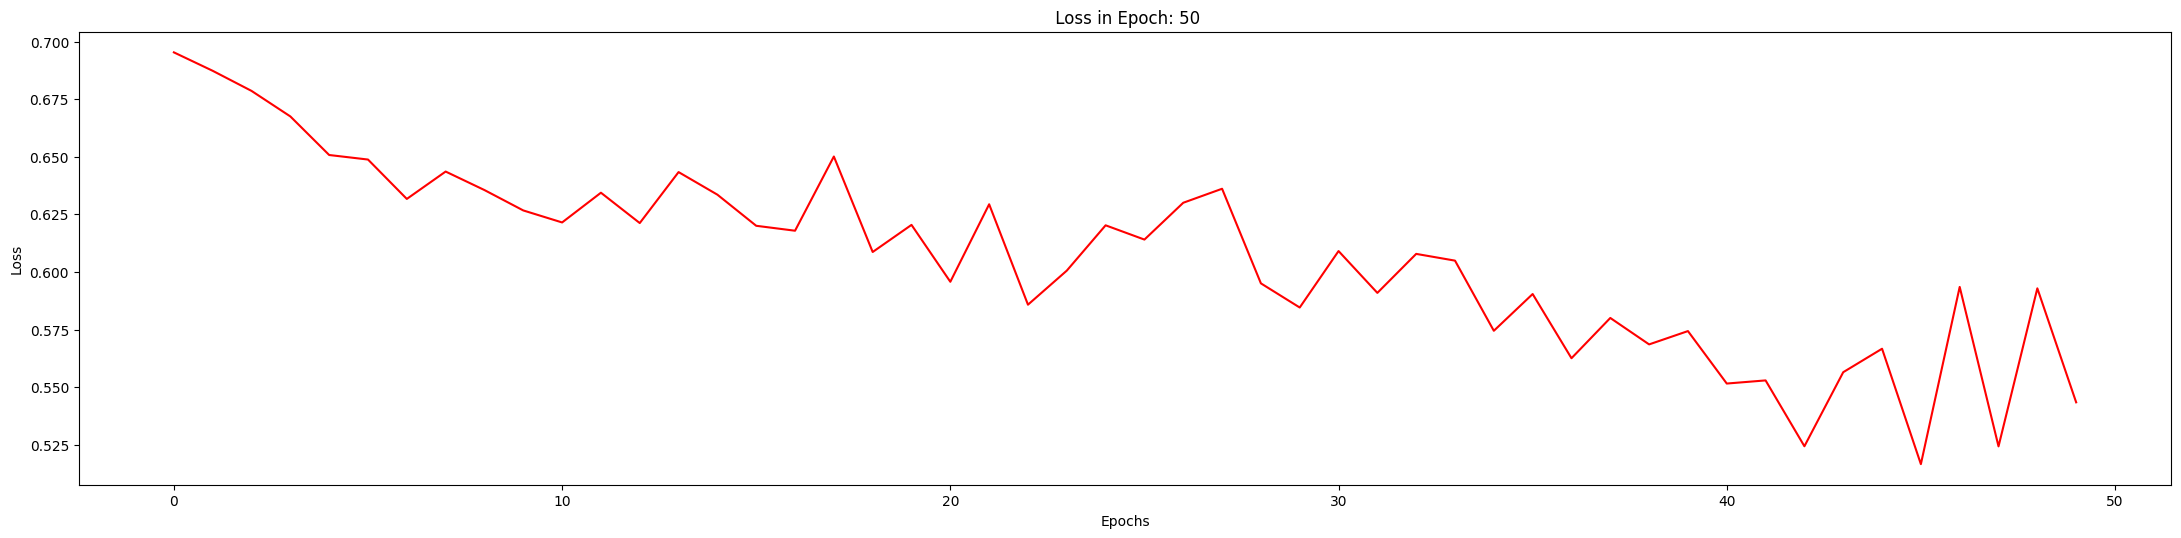

Epoch: 051, Model Loss: 0.5095
Epoch: 052, Model Loss: 0.5335
Epoch: 053, Model Loss: 0.5509
Epoch: 054, Model Loss: 0.5024
Epoch: 055, Model Loss: 0.5204
Epoch: 056, Model Loss: 0.5144
Epoch: 057, Model Loss: 0.4960
Epoch: 058, Model Loss: 0.4931
Epoch: 059, Model Loss: 0.5228
Epoch: 060, Model Loss: 0.4794
Epoch: 061, Model Loss: 0.4872
Epoch: 062, Model Loss: 0.5102
Epoch: 063, Model Loss: 0.5229
Epoch: 064, Model Loss: 0.4374
Epoch: 065, Model Loss: 0.4876
Epoch: 066, Model Loss: 0.4635
Epoch: 067, Model Loss: 0.4883
Epoch: 068, Model Loss: 0.4991
Epoch: 069, Model Loss: 0.4647
Epoch: 070, Model Loss: 0.4562
Epoch: 071, Model Loss: 0.4748
Epoch: 072, Model Loss: 0.4454
Epoch: 073, Model Loss: 0.4747
Epoch: 074, Model Loss: 0.4625
Epoch: 075, Model Loss: 0.4658
Epoch: 076, Model Loss: 0.4628
Epoch: 077, Model Loss: 0.4521
Epoch: 078, Model Loss: 0.4953
Epoch: 079, Model Loss: 0.4409
Epoch: 080, Model Loss: 0.4548
Epoch: 081, Model Loss: 0.4380
Epoch: 082, Model Loss: 0.4594
Epoch: 0

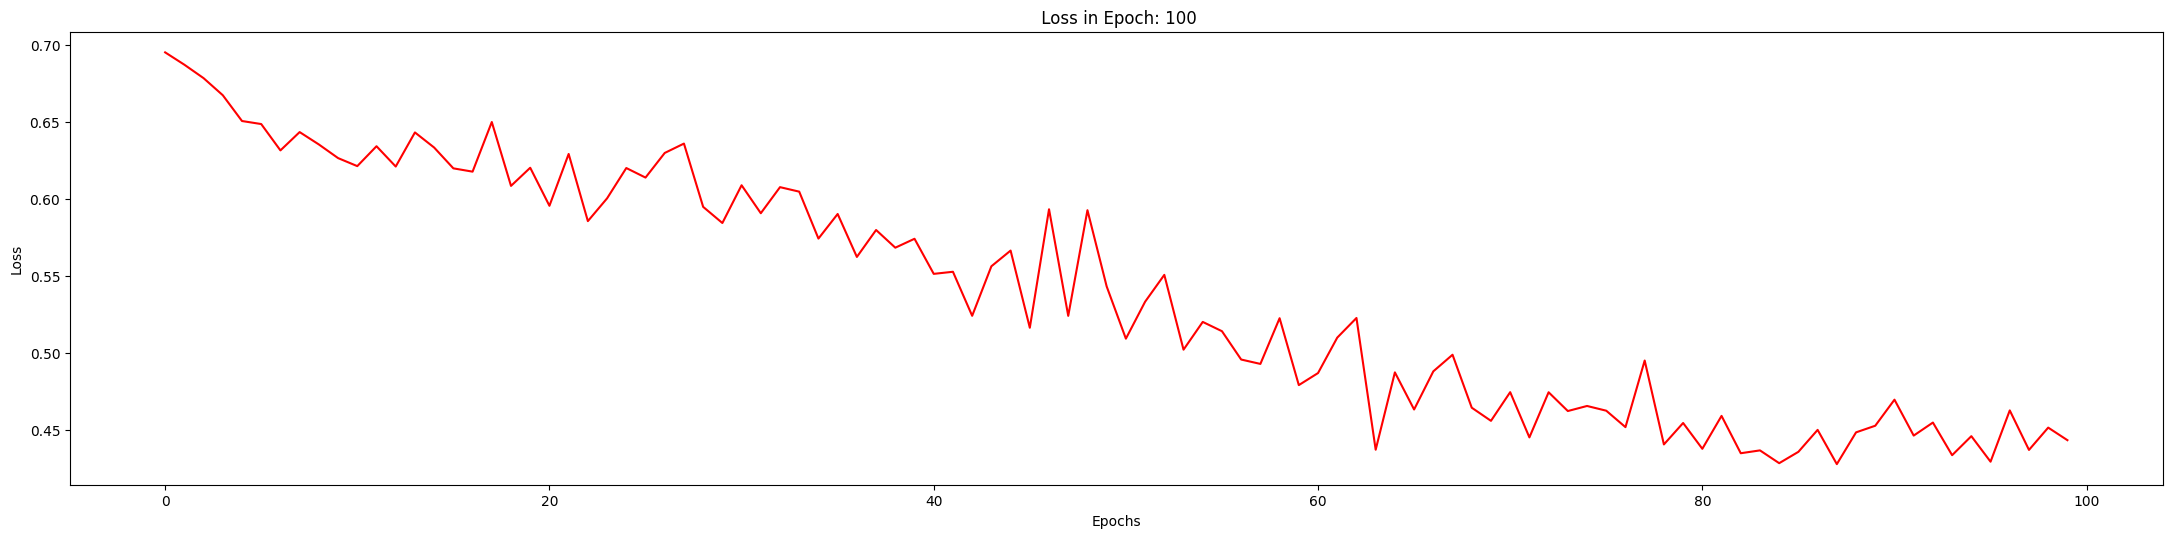

Epoch: 101, Model Loss: 0.4402
Epoch: 102, Model Loss: 0.4393
Epoch: 103, Model Loss: 0.4421
Epoch: 104, Model Loss: 0.4292
Epoch: 105, Model Loss: 0.4385
Epoch: 106, Model Loss: 0.4445
Epoch: 107, Model Loss: 0.4607
Epoch: 108, Model Loss: 0.4820
Epoch: 109, Model Loss: 0.4282
Epoch: 110, Model Loss: 0.4518
Epoch: 111, Model Loss: 0.4459
Epoch: 112, Model Loss: 0.4233
Epoch: 113, Model Loss: 0.4256
Epoch: 114, Model Loss: 0.4258
Epoch: 115, Model Loss: 0.4142
Epoch: 116, Model Loss: 0.4534
Epoch: 117, Model Loss: 0.4280
Epoch: 118, Model Loss: 0.4406
Epoch: 119, Model Loss: 0.4455
Epoch: 120, Model Loss: 0.4292
Epoch: 121, Model Loss: 0.4426
Epoch: 122, Model Loss: 0.4295
Epoch: 123, Model Loss: 0.4167
Epoch: 124, Model Loss: 0.4492
Epoch: 125, Model Loss: 0.4410
Epoch: 126, Model Loss: 0.4280
Epoch: 127, Model Loss: 0.4450
Epoch: 128, Model Loss: 0.4305
Epoch: 129, Model Loss: 0.4588
Epoch: 130, Model Loss: 0.4544
Epoch: 131, Model Loss: 0.4310
Epoch: 132, Model Loss: 0.4542
Epoch: 1

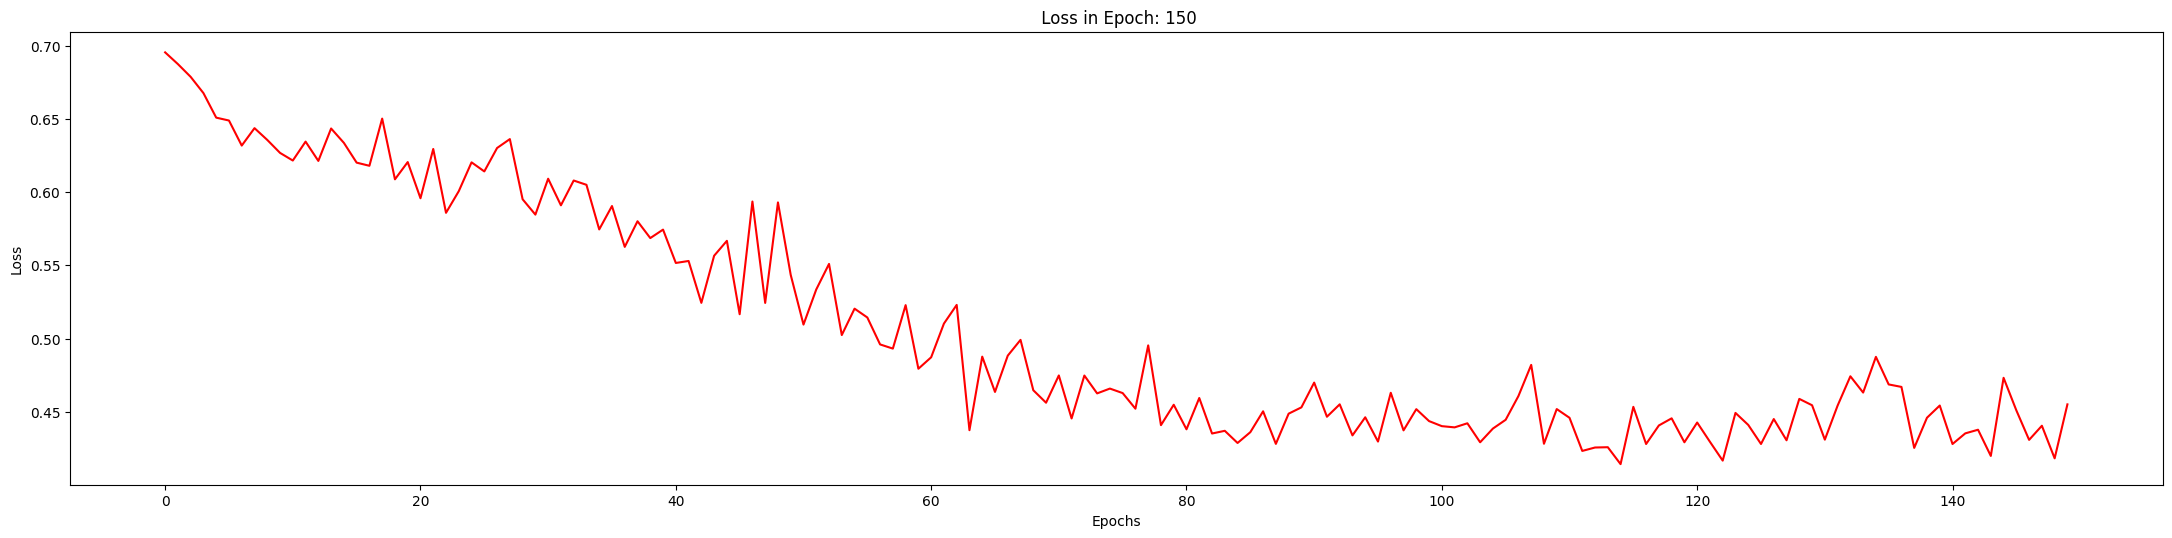

Epoch: 151, Model Loss: 0.4513
Epoch: 152, Model Loss: 0.4799
Epoch: 153, Model Loss: 0.4546
Epoch: 154, Model Loss: 0.4498
Epoch: 155, Model Loss: 0.4377
Epoch: 156, Model Loss: 0.4541
Epoch: 157, Model Loss: 0.4334
Epoch: 158, Model Loss: 0.4213
Epoch: 159, Model Loss: 0.4178
Epoch: 160, Model Loss: 0.4276
Epoch: 161, Model Loss: 0.4499
Epoch: 162, Model Loss: 0.4355
Epoch: 163, Model Loss: 0.4363
Epoch: 164, Model Loss: 0.4313
Epoch: 165, Model Loss: 0.4711
Epoch: 166, Model Loss: 0.4192
Epoch: 167, Model Loss: 0.4363
Epoch: 168, Model Loss: 0.4184
Epoch: 169, Model Loss: 0.4577
Epoch: 170, Model Loss: 0.4442
Epoch: 171, Model Loss: 0.4455
Epoch: 172, Model Loss: 0.4421
Epoch: 173, Model Loss: 0.4400
Epoch: 174, Model Loss: 0.4449
Epoch: 175, Model Loss: 0.4287
Epoch: 176, Model Loss: 0.4737
Epoch: 177, Model Loss: 0.4718
Epoch: 178, Model Loss: 0.4598
Epoch: 179, Model Loss: 0.4618
Epoch: 180, Model Loss: 0.4494
Epoch: 181, Model Loss: 0.4211
Epoch: 182, Model Loss: 0.4813
Epoch: 1

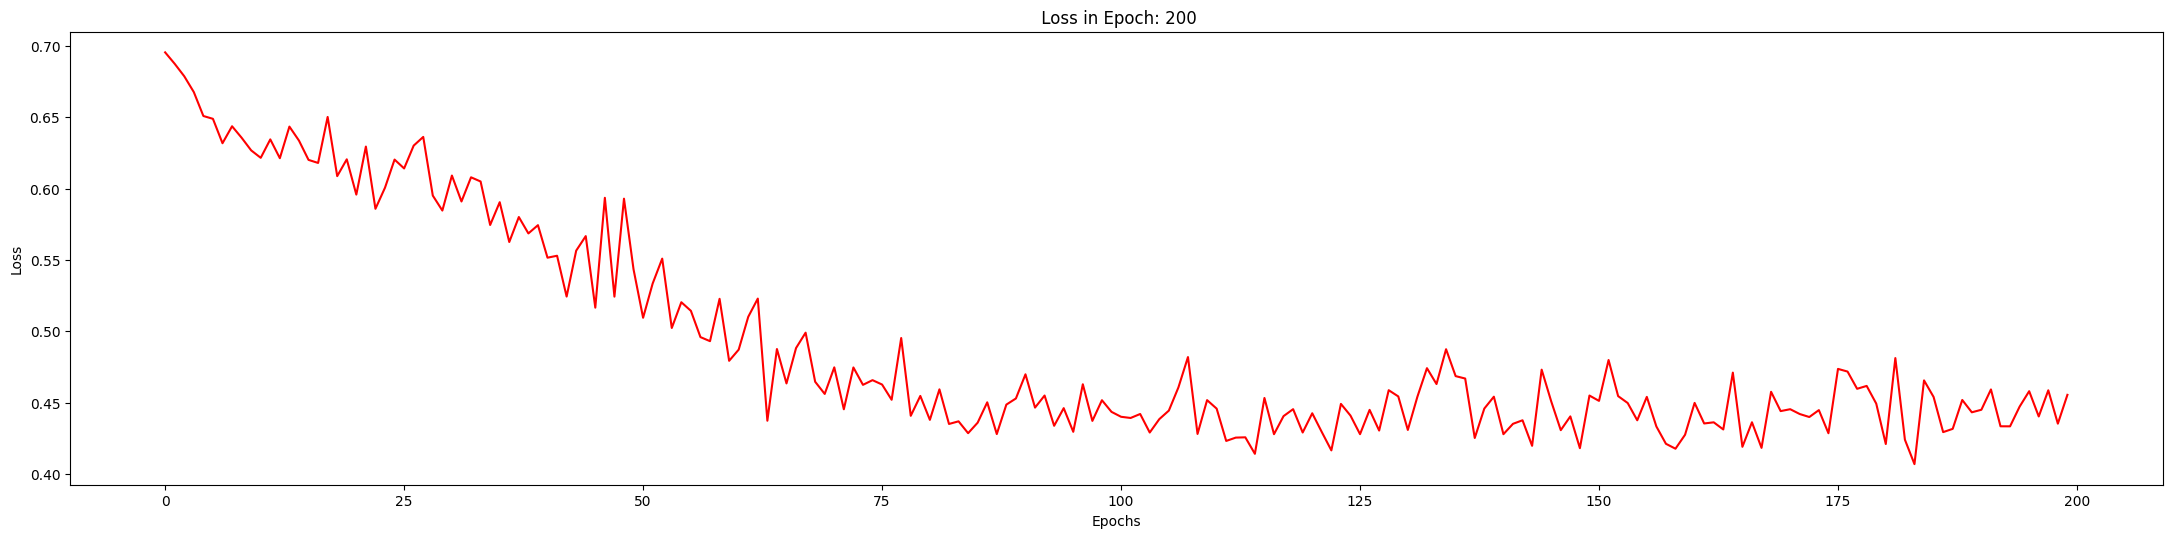

Epoch: 201, Model Loss: 0.4440
Epoch: 202, Model Loss: 0.4350
Epoch: 203, Model Loss: 0.4308
Epoch: 204, Model Loss: 0.4293
Epoch: 205, Model Loss: 0.4516
Epoch: 206, Model Loss: 0.4469
Epoch: 207, Model Loss: 0.4226
Epoch: 208, Model Loss: 0.4621
Epoch: 209, Model Loss: 0.4236
Epoch: 210, Model Loss: 0.4424
Epoch: 211, Model Loss: 0.4717
Epoch: 212, Model Loss: 0.4501
Epoch: 213, Model Loss: 0.4351
Epoch: 214, Model Loss: 0.4493
Epoch: 215, Model Loss: 0.4535
Epoch: 216, Model Loss: 0.4612
Epoch: 217, Model Loss: 0.4594
Epoch: 218, Model Loss: 0.4604
Epoch: 219, Model Loss: 0.4289
Epoch: 220, Model Loss: 0.5027
Epoch: 221, Model Loss: 0.4781
Epoch: 222, Model Loss: 0.4212
Epoch: 223, Model Loss: 0.4391
Epoch: 224, Model Loss: 0.4656
Epoch: 225, Model Loss: 0.4680
Epoch: 226, Model Loss: 0.4333
Epoch: 227, Model Loss: 0.4625
Epoch: 228, Model Loss: 0.4481
Epoch: 229, Model Loss: 0.4276
Epoch: 230, Model Loss: 0.4695
Epoch: 231, Model Loss: 0.4644
Epoch: 232, Model Loss: 0.4400
Epoch: 2

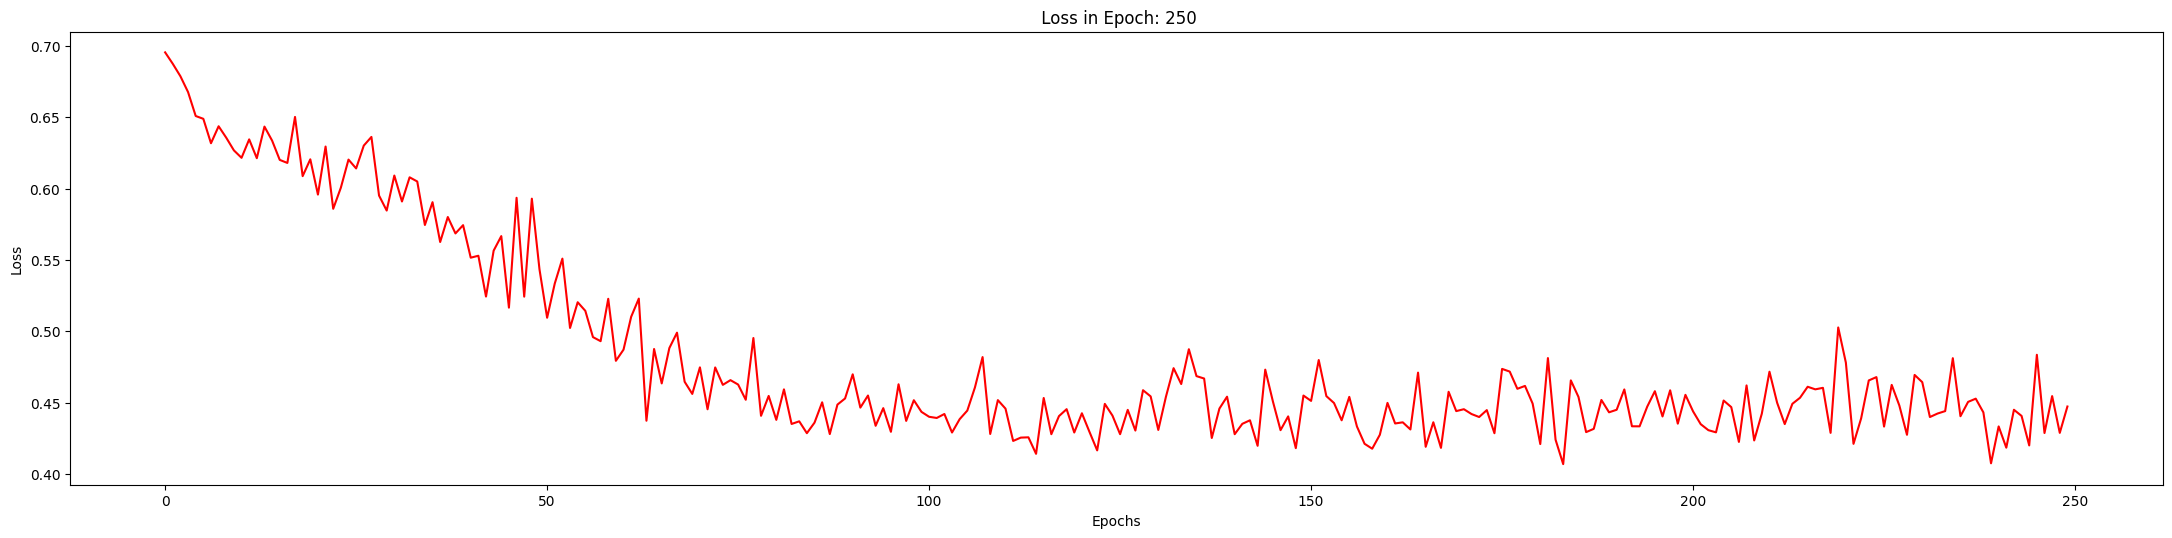

Epoch: 251, Model Loss: 0.4339
Epoch: 252, Model Loss: 0.4594
Epoch: 253, Model Loss: 0.4671
Epoch: 254, Model Loss: 0.4596
Epoch: 255, Model Loss: 0.4371
Epoch: 256, Model Loss: 0.4418
Epoch: 257, Model Loss: 0.4736
Epoch: 258, Model Loss: 0.4109
Epoch: 259, Model Loss: 0.4292
Epoch: 260, Model Loss: 0.4470
Epoch: 261, Model Loss: 0.4687
Epoch: 262, Model Loss: 0.4320
Epoch: 263, Model Loss: 0.4503
Epoch: 264, Model Loss: 0.4654
Epoch: 265, Model Loss: 0.4253
Epoch: 266, Model Loss: 0.4550
Epoch: 267, Model Loss: 0.4724
Epoch: 268, Model Loss: 0.4513
Epoch: 269, Model Loss: 0.4545
Epoch: 270, Model Loss: 0.4326
Epoch: 271, Model Loss: 0.4762
Epoch: 272, Model Loss: 0.4415
Epoch: 273, Model Loss: 0.4862
Epoch: 274, Model Loss: 0.4525
Epoch: 275, Model Loss: 0.4416
Epoch: 276, Model Loss: 0.4473
Epoch: 277, Model Loss: 0.4397
Epoch: 278, Model Loss: 0.4413
Epoch: 279, Model Loss: 0.4279
Epoch: 280, Model Loss: 0.4336
Epoch: 281, Model Loss: 0.4474
Epoch: 282, Model Loss: 0.4234
Epoch: 2

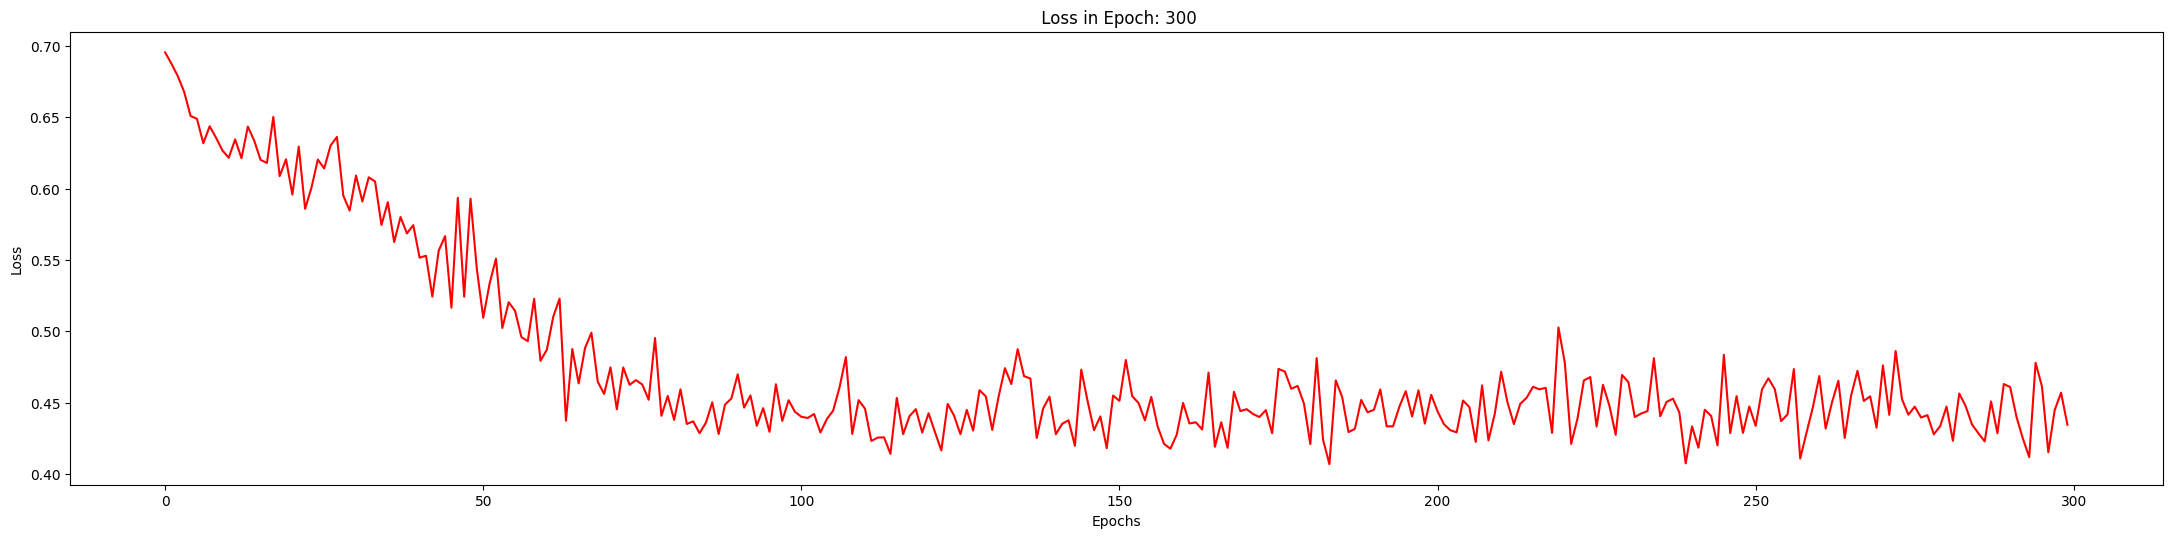

In [19]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index)

## **Test**

In [20]:
GNN_Model_test_predicted_labels = []

def GNN_Model_test(test_loader):
    GNN_Model.eval()
    correct = 0
    for batch_of_graphs in test_loader:
        #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        #GNN_Model_test_pred = soft.argmax(dim=1).tolist()[0]

        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs)
        #GNN_Model_test_pred = softmaxed_h2.argmax(dim=1)

        concatination_list_of_poolings, prediction_output = GNN_Model(batch_of_graphs, None)
        GNN_Model_test_pred = prediction_output.argmax(dim=1).tolist()[0]

        GNN_Model_test_predicted_labels.append(GNN_Model_test_pred)

        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())

    return correct / len(test_loader.dataset), GNN_Model_test_predicted_labels

In [21]:
GNN_Model_test_acc, predicted_labels = GNN_Model_test(test_dataloader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')


Test Accuracy: 0.6316


In [22]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()

        #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        #GNN_test_pred = soft.argmax(dim=1)

        concatination_list_of_poolings, prediction_output = GNN_Model(batched_data, None)
        GNN_Model_test_pred = prediction_output.argmax(dim=0).tolist()

        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [23]:
samples_time = instance_time(test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.00560323199999857, 0.002892979999955969, 0.0026249769999822092, 0.0024344530000917075, 0.0025063890000183164, 0.002435851999962324, 0.0024683309999318226, 0.005072573999996166, 0.00394566499994653, 0.004010313999970094, 0.003960757999948328, 0.003974531999915598, 0.004320318000054613, 0.004109771000003093, 0.002960408000035386, 0.002732691000005616, 0.0025963080000792615, 0.0025655819999883533, 0.0024654420000160826, 0.002468819999990046, 0.002323344999922483, 0.0024855869999100833, 0.0024002369999607254, 0.002326366000033886, 0.0023182999999562526, 0.0023117700000057084, 0.002316714000016873, 0.0023440769999751865, 0.0025323510000134775, 0.002382561999979771, 0.002383076999990408, 0.002827695000064523, 0.0023450899999488684, 0.002306618999909915, 0.002450482999961423, 0.0023771320001060303, 0.0023155009999982212, 0.0023499669999864636]


In [24]:
real_labels = []
for graph in test_dataloader:
    real_labels.append(graph.y.tolist()[0])

In [25]:
print("predicted_labels: ", predicted_labels)
print("real_labels: ", real_labels)
print("Test Accuracy: ", metrics.accuracy_score(real_labels, predicted_labels))

predicted_labels:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]
real_labels:  [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Test Accuracy:  0.631578947368421


In [26]:
Auc_Roc = metrics.roc_auc_score(real_labels, predicted_labels)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predicted_labels)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predicted_labels, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predicted_labels, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5595238095238095 0.8026315789473684 0.631578947368421 24


Check

In [27]:
print(GNN_Model)
test_dataloader_example = DataLoader(test_dataset, batch_size=1, shuffle=False)
for batch in test_dataloader_example:
    #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch)
    #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch)
    #new_X, new_adjacency_1, graph_sage1_output, new_X_2, new_adjacency_2, graph_sage2_output, linear1_output, linear2_output, linear3_output = GNN_Model(batch, None)
    concatination_list_of_poolings, prediction_output = GNN_Model(batch, None)
    break
#print(soft)
#print(softmaxed_h2)
#print(linear3_output)
print(train_dataset[0].x)

DIFFPOOL_Model(
  (diffpool_layers): Sequential(
    (0): Batched_DiffPool_Layer(
      (diffpool_embedding): Batched_DiffPool_Embedding_Layer(
        (DiffPool_Embedding): ModuleList(
          (0): GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=7, out_features=64, bias=True)
          )
          (1-2): 2 x GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )
      (diffpool_assignment): Batched_DiffPool_Assignment_Layer(
        (diffPool_assignment): ModuleList(
          (0): GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=7, out_features=64, bias=True)
          )
          (1-2): 2 x GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )
    )
  )
  (last_extra_embedding): Batched_DiffPool_Embedding_Layer(
    (DiffPool_Embedding): Modul

## **Explainer**

In [28]:
from torch.autograd import graph
from typing import Any, Dict, Optional, Union


class my_explainer_handler:
    def __init__(self, model: torch.nn.Module, algorithm, task_level, mode):
        self.model = model
        self.method = algorithm
        self.mode = mode

    def __call__(self, graph_to_explain):
        print(graph_to_explain)
        x = graph_to_explain.x
        edge_index = graph_to_explain.edge_index
        graph_batch = graph_to_explain.batch

        prediction = self.get_prediction(graph_to_explain)
        prediction = self.get_target(prediction)
        #Explainer = GNNExplainer(200, 0.001)
        #exp = Explainer(dataset[0])
        print(prediction)

    def get_prediction(self, graph):
        self.model.eval()
        concatination_list_of_poolings, prediction_output = GNN_Model(graph)
        #print((soft > 0.5).long().view(-1))
        #print("THis is the output of the model", soft)
        return prediction_output

    def get_target(self, pred):
        prediction = (pred > 0.5).long().view(-1)
        return prediction

In [29]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
print("input: ", input)
output = m(input)
print("output: ", output)


lsm = nn.LogSoftmax(dim=1)
#input = torch.randn(2, 3)
output2 = lsm(input)
print("lof output: ", output2)



print("soft of log output: ", m(output2))

input:  tensor([[-0.5260, -0.5089,  0.3408],
        [-0.5057, -0.9632,  0.1263]])
output:  tensor([[0.2274, 0.2314, 0.5412],
        [0.2846, 0.1801, 0.5354]])
lof output:  tensor([[-1.4808, -1.4637, -0.6140],
        [-1.2568, -1.7144, -0.6248]])
soft of log output:  tensor([[0.2274, 0.2314, 0.5412],
        [0.2846, 0.1801, 0.5354]])


## **GNNExplainer**

In [30]:
from time import perf_counter
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
loss_fn = F.binary_cross_entropy_with_logits
class GNNExplainer:
    coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
        'EPS': 1e-15,
        }
    def __init__(self, GNN_Model, Exp_Epoch, Exp_lr):

        self.GNN_Model = GNN_Model
        self.loss_fn = F.binary_cross_entropy_with_logits

        self.explainer_epochs = Exp_Epoch
        self.explainer_lr = Exp_lr
        self.node_mask = self.edge_mask = None
        self.softmax = nn.Softmax(dim=-1)


    def initialize_masks(self, graph_to_explain):
        #(N, F), E = (len(graph_to_explain.x), len(graph_to_explain.x[0])), len(graph_to_explain.edge_index[1])
        (N, F), E = (1, len(graph_to_explain.x[0])), len(graph_to_explain.edge_index[1])
        std = 0.1
        self.node_mask = Parameter(torch.randn(N, F) * std, requires_grad=True)
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = Parameter(torch.randn(E) * std, requires_grad=True)

        for module in self.GNN_Model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask
                module._apply_sigmoid = True

    def explainer_loss(self, By_Perturbation_predicted_label, predicted_label):
        By_Perturbation_predicted_label = By_Perturbation_predicted_label.to(torch.float32)
        predicted_label = predicted_label.to(torch.float32)
        #print('By_Perturbation_predicted_label', By_Perturbation_predicted_label)
        #print('predicted_label', predicted_label)
        loss_in_explainer_stage = self.loss_fn(By_Perturbation_predicted_label, predicted_label)



        m = self.edge_mask.sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])                                             ######.         MARGINALIZE Over All Feature Subsets
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['edge_size'] * edge_reduce(m)
        ent = -m * torch.log(m + self.coeffs['EPS']) - (1 - m) * torch.log(1 - m + self.coeffs['EPS'])
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_mask.sigmoid()                                                                            ######.         Element-wise Entropy for structural and node feature masks to be discrete
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + self.coeffs['EPS']) - (1 - m) * torch.log(1 - m + self.coeffs['EPS'])
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['node_feat_ent'] * ent.mean()


        return loss_in_explainer_stage

    def explainer_train_step(self, graph_to_explain, predicted_label):
        new_graph_by_masks = graph_to_explain

        parameters = [self.node_mask]
        parameters.append(self.edge_mask)

        explainer_optimizer = torch.optim.Adam(parameters, lr=self.explainer_lr)

        for i in range(self.explainer_epochs):
            explainer_optimizer.zero_grad()

            h_node = graph_to_explain.x * self.node_mask.sigmoid()
            new_graph_by_masks.x = h_node


            #By_Perturbation_Output_of_Hidden_Layers, By_Perturbation_pooling_layer_output, By_Perturbation_gcn_model_output, By_Perturbation_soft_y_hat = self.GNN_Model(new_graph_by_masks)
            #By_Perturbation_predicted_label = By_Perturbation_soft_y_hat.argmax(dim=-1)

            #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = self.GNN_Model(new_graph_by_masks)
            #By_Perturbation_predicted_label = softmaxed_h2.argmax(dim=-1)

            concatination_list_of_poolings, prediction_output = GNN_Model(new_graph_by_masks, self.edge_mask.tolist())
            By_Perturbation_predicted_label = prediction_output.argmax(dim=-1)

            loss = self.explainer_loss(By_Perturbation_predicted_label, predicted_label)

            #print(loss)

            loss.backward()
            explainer_optimizer.step()
            #print(self.edge_mask)
            #print(self.node_mask)

    def post_process_mask(self, mask, apply_soft):
        #print(apply_sig)
        if apply_soft:
            mask = mask.detach()
            mask = self.softmax(mask)
            return mask
        else:
            return mask

    def node_post_process_mask(self, node_mask, graph):
        attributed_graph = []
        attributed_graph_normalized = []
        attributed_graph_standardized = []
        for node in graph.x:
            attributed_graph.append(sum(np.multiply(node.tolist(), node_mask.tolist()[0])))

        for score in attributed_graph:
            attributed_graph_normalized.append(abs(((score-min(attributed_graph))*100/(max(attributed_graph)-min(attributed_graph)))).tolist())

        for score in attributed_graph_normalized:
            attributed_graph_standardized.append(abs(score / max(attributed_graph_normalized)))
        #print("attributed_graph_standardized: ", len(attributed_graph_standardized), attributed_graph_standardized)
        return attributed_graph_standardized


    def train_explainer(self, main_graph_to_explain, graph_to_explain, class_type):
        #new_graph_by_masks = graph_to_explain
        with torch.no_grad():
            #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = self.GNN_Model(graph_to_explain)
            #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = self.GNN_Model(graph_to_explain)
            concatination_list_of_poolings, soft = GNN_Model(graph_to_explain, None)
        #predicted_label = softmaxed_h2.argmax(dim=-1)
        #print("before softmax: ", soft)
        if class_type == "correct":
            #predicted_label = softmaxed_h2.argmax(dim=-1)
            predicted_label = soft.argmax(dim=-1)
        else:
            #predicted_label = softmaxed_h2.argmin(dim=-1)
            predicted_label = soft.argmin(dim=-1)
        #print("after softmax: ", predicted_label)

        self.initialize_masks(graph_to_explain)
        self.explainer_train_step(graph_to_explain, predicted_label)

        node_mask = self.node_post_process_mask(self.node_mask, main_graph_to_explain)
        edge_mask = self.post_process_mask(self.edge_mask, True)
        return node_mask, edge_mask



    def __call__(self, graph_to_explain, class_type):
        new_graph_by_masks = deepcopy(graph_to_explain.detach())
        node_mask, edge_mask = self.train_explainer(graph_to_explain, new_graph_by_masks, class_type)
        #node_mask = torch.squeeze(node_mask)
        #print("Node Mask: ", node_mask)
        #print("Edge Mask: ", edge_mask)
        return node_mask, edge_mask

#EXP = GNNExplainer(GNN_Model, 200, 0.001)
#for batch in test_dataloader_example:
#    node_mask, edge_mask = EXP(batch)
#class_type = "correct"

def attributions_for_contrastivity(graph, correct_mask, incorrect_mask):
    correct_attributions = []
    incorrect_attributions = []

    return correct_mask, incorrect_mask

def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold < score:
        return True
    else:
        return False

def binarize_saliency_maps(graph, correct_node_mask, incorrect_node_mask, importance_threshold):
    correct_attributions, incorrect_attributions = attributions_for_contrastivity(graph, correct_node_mask, incorrect_node_mask)
    correct_binary_score = ''
    incorrect_binary_score = ''
    for i in range(len(correct_attributions)):
        if is_salient((correct_attributions[i]), importance_threshold * (max(correct_attributions)-min(correct_attributions))):
            correct_binary_score += '1'
        else:
            correct_binary_score += '0'

    for i in range(len(incorrect_attributions)):
        if is_salient((incorrect_attributions[i]), importance_threshold * (max(incorrect_attributions)-min(incorrect_attributions))):
            incorrect_binary_score += '1'
        else:
            incorrect_binary_score += '0'
    return correct_binary_score, incorrect_binary_score



def saliency_list_sparsity(graph, correct_node_mask, incorrect_node_mask, importance_threshold):
    correct_attributions, incorrect_attributions = attributions_for_contrastivity(graph, correct_node_mask, incorrect_node_mask)
    correct_idicator = []
    incorrect_indicator = []
    for i in range(len(correct_attributions)):

            if is_salient((correct_attributions[i]), importance_threshold * (max(correct_attributions)-min(correct_attributions))):
                correct_idicator.append(1)
            else:
                correct_idicator.append(0)

    for i in range(len(incorrect_attributions)):

            if is_salient((incorrect_attributions[i]), importance_threshold * (max(incorrect_attributions)-min(incorrect_attributions))):
                incorrect_indicator.append(1)
            else:
                incorrect_indicator.append(0)
    return correct_idicator, incorrect_indicator

def compute_sparsity(graph, correct_node_mask, incorrect_node_mask, importance_threshold):
    correct_idicator, incorrect_indicator = saliency_list_sparsity(graph, correct_node_mask, incorrect_node_mask, importance_threshold)
    sparsity = 1 - ((sum(correct_idicator) + sum(incorrect_indicator))/(len(graph.x)*len(graph.x[0])))
    return sparsity

def compute_contrastivity(graph, correct_node_mask, incorrect_node_mask, importance_threshold):
    correct_binary_score, incorrect_binary_score = binarize_saliency_maps(graph, correct_node_mask, incorrect_node_mask, importance_threshold)
    print("correct_binary_score: ", correct_binary_score)
    print("incorrect_binary_score: ", incorrect_binary_score)
    h_distance = hamming([correct_binary_score], [incorrect_binary_score])
    #print("hamming distance: ", h_distance)
    return h_distance

importance_threshold = 0.14
contrastivity_list = []
sparsity_list = []
times = []
class0_list = []
class1_list = []
for graph in test_dataloader:
    t1 = perf_counter()
    EXP = GNNExplainer(GNN_Model, 200, 0.001)
    correct_node_mask, correct_edge_mask = EXP(graph, "correct")
    times.append(perf_counter()-t1)
    class0_list.append(correct_node_mask)
    print("correct_node_mask: ", correct_node_mask)
    EXP = GNNExplainer(GNN_Model, 200, 0.001)
    incorrect_node_mask, incorrect_edge_mask = EXP(graph, "incorrect")
    class1_list.append(incorrect_node_mask)
    h_distance = compute_contrastivity(graph, correct_node_mask, incorrect_node_mask, importance_threshold)
    contrastivity_list.append(h_distance)
    sparsity = compute_sparsity(graph, correct_node_mask, incorrect_node_mask, importance_threshold)
    sparsity_list.append(sparsity)

print("Contrastivity: ", statistics.mean(contrastivity_list))
print("Sparsity: ", statistics.mean(sparsity_list))
print("AVG. Time: ", sum(times)/len(times))


#print("Node Mask: ", node_mask)
#print("train_dataset[0]: ",train_dataset[0].x)
#print("Edge Mask: ", edge_mask)

correct_node_mask:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9806304550975306, 1.0, 1.0]
correct_binary_score:  00000000000000111
incorrect_binary_score:  11111111111111011
correct_node_mask:  [0.0634232812927965, 0.0634232812927965, 0.0634232812927965, 0.0634232812927965, 0.0634232812927965, 0.0634232812927965, 0.0, 0.0634232812927965, 0.0634232812927965, 0.0634232812927965, 0.0, 1.0, 1.0]
correct_binary_score:  0000000000011
incorrect_binary_score:  1111111111100
correct_node_mask:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.45215417602790153, 0.45215417602790153]
correct_binary_score:  1111111011011
incorrect_binary_score:  1111111011011
correct_node_mask:  [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.24864486212047848, 0.24864486212047848]
correct_binary_score:  111010111011
incorrect_binary_score:  111010111011
correct_node_mask:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.9069

In [31]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [32]:
fid_plus_xmethod_example = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model, test_data=test_dataset)
fid_plus_score = fid_plus_xmethod_example.my_fidelity(saliency_class0=class0_list, saliency_class1=class1_list,
                                                      importance_threshold=0.01, style="Node")
print(fid_plus_score)

0.11309523809523808


In [33]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_minus as eval_xai_fid_minus
eval_xai_fid_minus = reload(eval_xai_fid_minus)

In [34]:
fid_minus_xmethod_example = eval_xai_fid_minus.evalaution_of_xmethods_fidelity_minus(a_trained_model=GNN_Model, test_data=test_dataset)
fid_minus_score = fid_minus_xmethod_example.my_fidelity(saliency_class0=class0_list, saliency_class1=class1_list,
                                                        importance_threshold=0.01, style="Node")
print(fid_minus_score)

0.08333333333333337


In [35]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [36]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, class0_list,
                                                                     class1_list, importance_threshold=0.5,
                                                                     contrast_coeff=1e+11)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.43060246798788326


In [37]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [38]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=GNN_Model, test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, class0_list, class1_list, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.5057118200680636


In [39]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_stability as eval_xai_stability
eval_xai_stability = reload(eval_xai_stability)

In [40]:
stability = eval_xai_stability.evalaution_of_xmethods_stability(GNN_Model, test_dataset)
perturbed_test_dataset = stability.perturb_node_features_of_dataset(test_dataset, 0.1, 0.1)

In [41]:
times_perturbed = []
class0_list_perturbed = []
class1_list_perturbed = []
for graph in perturbed_test_dataset:
    t1 = perf_counter()
    EXP = GNNExplainer(GNN_Model, 200, 0.001)
    correct_node_mask, correct_edge_mask = EXP(graph, "correct")
    times_perturbed.append(perf_counter()-t1)
    class0_list_perturbed.append(correct_node_mask)
    print("correct_node_mask: ", correct_node_mask)
    EXP = GNNExplainer(GNN_Model, 200, 0.001)
    incorrect_node_mask, incorrect_edge_mask = EXP(graph, "incorrect")
    class1_list_perturbed.append(incorrect_node_mask)

correct_node_mask:  [0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.33703331144510174, 0.0, 1.0, 1.0]
correct_node_mask:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.7651195485521072, 0.7651195485521072]
correct_node_mask:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.20817443559554413, 0.20817443559554413]
correct_node_mask:  [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.14461423451082814, 0.14461423451082814]
correct_node_mask:  [0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191, 0.770366959488191

In [42]:
stability_score = stability.my_stability(normal_saliency_class0=class0_list, perturbed_saliency_class0=class0_list_perturbed,
                                         normal_saliency_class1=class0_list, perturbed_saliency_class1=class1_list_perturbed,
                                         top_k_features=2, importance_threshold=0.1, style='Node')

In [43]:
print("stability: ", stability_score)

stability:  0.16969203635529878


In [ ]:
explain(train_dataset[0])

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])
tensor([0, 0])


In [ ]:
a = torch.randn(4, 5)
print(a)
max_elements, max_indexes = torch.max(a, 1)
print(max_elements)

tensor([[ 0.5067,  0.2206, -0.5649, -1.2778, -0.6966],
        [ 0.1835, -0.0956, -1.1218, -0.4059, -1.1645],
        [-1.3899, -0.0315,  0.7966,  0.5035,  0.0584],
        [-0.4845, -1.6169,  1.3013, -0.3363, -0.0124]])
tensor([0.5067, 0.1835, 0.7966, 1.3013])


In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
    preds = []
    reals = []

    your_model.eval()
    for batched_data in your_dataset:
        #Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
        #final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = your_model(batched_data)
        new_X, new_adjacency_1, graph_sage1_output, new_X_2, new_adjacency_2, graph_sage2_output, linear1_output, linear2_output, soft = GNN_Model(batched_data, None)

        preds.append(soft.cpu().detach())

    for i, batched_graph in enumerate(your_dataset):
        reals.append(batched_graph.y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    print("preds: ", preds)
    preds, max_idxs = torch.max(preds[:], dim=-1)
    #print(preds)
    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc


def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold <= score:
        return True
    else:
        return False



def drop_important_nodes(your_dataset, importance_threshold):
    attribution_scores = []
    attribution_scores_time = []
    for i, batched_graph in enumerate(your_dataset):
        t1 = perf_counter()
        gnn_explainer = GNNExplainer(GNN_Model, 200, 0.01)
        graph_mask, edge_mask = gnn_explainer(batched_graph, "correct")
        attribution_scores_time.append(perf_counter()-t1)
        #graph_mask = torch.squeeze(graph_mask)
        print(i,"  ", graph_mask)
        attribution_scores.append(graph_mask)


    occluded_GNNgraph_list = []
    for i, batched_graph in enumerate(your_dataset):
        sample_graph = deepcopy(batched_graph.detach())
        #print(len(sample_graph.x))
        for j in range(len(sample_graph.x)):
                if is_salient(attribution_scores[i][j], importance_threshold * (max(attribution_scores[i])-min(attribution_scores[i]))):
                    #print("before: ", sample_graph.x[j])
                    sample_graph.x[j][:] = 0
                    #print(torch.zeros_like(sample_graph.x[j]))
                    #print("manipulated: ",sample_graph.x[j])
        occluded_GNNgraph_list.append(sample_graph)
    return occluded_GNNgraph_list, statistics.mean(attribution_scores_time)


def Fidelity_computation(your_model, your_dataset, importance_threshold):
    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
    new_graph_dataset, attribution_time = drop_important_nodes(your_dataset, importance_threshold)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

    print("auc_roc_before_droping_important_nodes: ", auc_roc_before_droping_important_nodes)
    print("auc_roc_after_droping_important_nodes: ", auc_roc_after_droping_important_nodes)
    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes, attribution_time

In [ ]:
fid_score, attribution_time = Fidelity_computation(GNN_Model, test_dataloader_example , 0.145)
print("fid_score: ", fid_score)
print("attribution_time: ", attribution_time)

preds:  tensor([0.1342, 0.8658, 0.1327, 0.8673, 0.1327, 0.8673, 0.1400, 0.8600, 0.1381,
        0.8619, 0.1362, 0.8638, 0.1401, 0.8599, 0.1330, 0.8670, 0.1343, 0.8657,
        0.1335, 0.8665, 0.1322, 0.8678, 0.1436, 0.8564, 0.1588, 0.8412, 0.1338,
        0.8662, 0.1382, 0.8618, 0.1377, 0.8623, 0.1338, 0.8662, 0.1448, 0.8552,
        0.1353, 0.8647, 0.1382, 0.8618, 0.1325, 0.8675, 0.1355, 0.8645, 0.1525,
        0.8475, 0.1423, 0.8577, 0.1334, 0.8666, 0.1316, 0.8684, 0.1438, 0.8562,
        0.1374, 0.8626, 0.1418, 0.8582, 0.1362, 0.8638, 0.1354, 0.8646, 0.1450,
        0.8550, 0.1385, 0.8615, 0.1324, 0.8676, 0.1402, 0.8598, 0.1438, 0.8562,
        0.1417, 0.8583, 0.1401, 0.8599])


TypeError: ignored

In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
l = [Explainability_name, task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, GNN_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_score, statistics.mean(contrastivity_list), statistics.mean(sparsity_list), attribution_time, statistics.mean(GNN_Model_training_time_per_epoch), samples_time]

In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
print("here, ", df.loc[6, 'Explicability Method Name'])
#df.loc[5, 'Fidelity'] = fid_EBP_label
#df.loc[5, 'Contrastivity'] = contrastivity_with_EBP
#df.loc[5, 'Sparsity'] = sparsity_with_EBP
#df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)

In [ ]:
#df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
#print("here, ", df.loc[3, 'Explicability Method Name'])

task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow(l)

#df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


In [ ]:
def saliency(dataset, gradients):
    Final= []
    for i in range(len(dataset)):
        Mid = []
        for node in dataset[i].x.detach().numpy():
            First = []
            for grad_list in gradients[i]:
                First.append(np.multiply(node, grad_list))
            Mid.append(First)
        Final.append(Mid)

    Saliency_Nodes = []
    for graph in Final:
        Node = []
        for node in graph:
            Grad = []
            for grad in node:
                Grad.append(sum(grad))
            Node.append(sum(Grad))
        #norm = [(float(i)-min(Node))/(max(Node)-min(Node)) for i in Node]
        norm = [(float(i))/(max(Node) + 1e-16) for i in Node]
        Saliency_Nodes.append(norm)
    return Saliency_Nodes

In [ ]:
def binarize_scores(your_dataset, grads_first_layer, importance_range):
    SA_attribution_scores = saliency(your_dataset, grads_first_layer)
    binarized_attribution_scores_list = []
    for scores in SA_attribution_scores:
        binary_score = ''
        for score in scores:
            if is_salient(abs(float(score)), importance_range):
                binary_score += '1'
            else:
                binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
    return binarized_attribution_scores_list

In [ ]:
for graph in test_dataset:
    node_mask, edge_mask = EXP(graph)